### Make boundary conditions for present day experiment

Based on observations from B-SOSE (http://sose.ucsd.edu/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import matplotlib.backends.backend_pdf
import gsw
import sys
# sys.path.append('/users/birgal/')
sys.path.append('/home/birgal/Documents/antarctic/analysis/')
from nemo_python.interpolation import interp_latlon_cf

#### Functions

In [2]:
def prepare_bdy_transect(var, month=1, bdy_lat=-50, convertS=False, convertT=False):
    # Arguments:
    # month --- to look at
    # bdy_lat --- latitude of boundary slice
    # Returns: WOA18 and B-SOSE salinity and temperatures at the specified boundary latitude

    # Load datasets:
    SOSE_var  = xr.open_dataset(f'{folder_SOSE}{var}_climatology_m{month:02}.nc')
    try:
        SOSE_var = SOSE_var.rename({'XC':'lon'})
    except:
        SOSE_var = SOSE_var.rename({'XG':'lon'})
    
    try:
        SOSE_var = SOSE_var.rename({'YC':'lat'})
    except:
        SOSE_var = SOSE_var.rename({'YG':'lat'})
        
    # Subset dataset:    
    SOSE_var  = SOSE_var.sel(lat=slice(bdy_lat-1, bdy_lat+1))
    
    # Find strip of points nearest bdy_lat (with edges +/- 1 and fill any zeros with NaNs:
    bdy_ind   = np.argmin(np.abs(SOSE_var.lat.values - bdy_lat))
    SOSE_varp = xr.where(SOSE_var[var].isel(lat=slice(bdy_ind-1, bdy_ind+2)) ==0, 
                         np.nan, SOSE_var.isel(lat=slice(bdy_ind-1, bdy_ind+2)))

    # And for SOSE, convert longitudes from 0-360 to -180 to 180 for pcolormesh
    SOSE_varp['lon'] = xr.where(SOSE_varp.lon  > 180, SOSE_varp.lon - 360, SOSE_varp.lon)
    SOSE_varp = SOSE_varp.sortby('lon')

    if (convertT and var=='THETA') or (convertT and convertS and var=='THETA'):
        print('     Coverting potential temperature to conservative temperature')
        SOSE_PS = prepare_bdy_transect('SALT', month=month, bdy_lat=bdy_lat) # practical salinity (JMD95)
        SOSE_p  = -1* SOSE_PS.Z * 1e-4 * 9.81 * 1035 # value for density makes a tiny difference
        SOSE_AS = gsw.conversions.SA_from_SP(SOSE_PS.SALT, SOSE_p, SOSE_PS.lon, SOSE_PS.lat)  
        SOSE_varp['THETA'] = gsw.conversions.CT_from_pt(SOSE_AS, SOSE_varp.THETA)
    elif convertS and var=='SALT':
        print('     Coverting practical salinity to absolute salinity')
        SOSE_p  = -1* SOSE_varp.Z * 1e-4 * 9.81 * 1035 # value for density makes a tiny difference
        SOSE_AS = gsw.conversions.SA_from_SP(SOSE_varp.SALT, SOSE_p, SOSE_varp.lon, SOSE_varp.lat)  
        SOSE_varp['SALT'] = SOSE_AS
    elif (convertT or convertS) or (convertT and convertS):
        raise Exception("Function can only convertT or convertS if the variables THETA or SALT are specified, respectively")    
    
    return SOSE_varp

In [3]:
def plot_bdy_transect(month, model_var1, model_var2, SOSE_var1, SOSE_var2, 
                      range1=(1,10), range2=(33.4, 34.6), ylim=(1500,0),
                      cmap1 = cmocean.cm.thermal, cmap2=cmocean.cm.haline):
                         
    fig, ax = plt.subplots(4,1, figsize=(18,12))

    fig.suptitle(f'Month: {month:02}', fontsize=12, fontweight='bold')
                          
    kwargs1 = {'vmin':range1[0], 'vmax':range1[1], 'cmap':cmap1, 'rasterized':True}
    kwargs2 = {'vmin':range2[0], 'vmax':range2[1], 'cmap':cmap2, 'rasterized':True}
    
    ax[0].set_title('B-SOSE observations')
    ax[1].set_title('Model boundary condition')
    ax[2].set_title('B-SOSE observations')
    ax[3].set_title('Model boundary condition')
    
    model_proc1  = model_var1.sortby('x')[list(model_var1.keys())[0]]
    model_proc2  = model_var2.sortby('x')[list(model_var2.keys())[0]]
    model_x, _   = np.meshgrid(model_proc1.x, model_proc1.Z)
    model_Z      = mesh.gdept_0.isel(time_counter=0, y=bdy_ind).sortby(model_proc1.x)
    print(model_x.shape, model_Z.values.shape)

    cm1 = ax[0].pcolormesh(SOSE_var1.lon, -1*SOSE_var1.Z, SOSE_var1[list(SOSE_var1.keys())[0]], **kwargs1)
    cm2 = ax[1].pcolormesh(model_x, model_Z, model_proc1.values, **kwargs1)
    cm3 = ax[2].pcolormesh(SOSE_var2.lon, -1*SOSE_var2.Z, SOSE_var2[list(SOSE_var2.keys())[0]], **kwargs2)
    cm4 = ax[3].pcolormesh(model_x, model_Z, model_proc2.values, **kwargs2)
    
    CB2 = fig.colorbar(cm2, ax=ax[0:2], fraction=0.03, extend='both', label=list(SOSE_obs[var1].keys())[0])
    CB4 = fig.colorbar(cm4, ax=ax[2:], fraction=0.03, extend='both', label=list(SOSE_obs[var2].keys())[0])
    
    for axis in ax.ravel():
        axis.set_ylabel('Depth (m)')
        axis.invert_yaxis()
        axis.set_ylim(ylim[0],ylim[1])
    ax[3].set_xlabel('Longitude')

    return fig, ax

In [4]:
def horizon_interp(month, vars):
    
    # Interpolate variables from observations from source to nemo grid along the longitude and latitude grid:
    datasets    = []
    SOSE_hinterp = {}
    for var in vars:
        print(f'Horizontal interpolation of variable: {var}')
        # Load dataset
        if var=='THETA': # if potential temperature, convert to conservative temperature
            dataset = prepare_bdy_transect(var, month=month, bdy_lat=bdy_lat, convertT=True) 
        elif var=='SALT': # if potential temperature, convert to conservative temperature
            dataset = prepare_bdy_transect(var, month=month, bdy_lat=bdy_lat, convertS=True) 
        else:
            dataset = prepare_bdy_transect(var, month=month, bdy_lat=bdy_lat) 
            
        try:
            dataset[var].Z # check whether dataset has multiple Z levels, and if so, loop over them
       
            datasets=[]
            for depth in sose.Z.values:
                source = xr.Dataset({'lon':dataset.lon, 'lat':dataset.lat, var :dataset[var].sel(Z=depth)})
            
                # Interpolate slices of depth levels along lat-lon: specify -1 and +1 NEMO grid cell on either side 
                data_interp = interp_latlon_cf(source, nemo.isel(y=slice(bdy_ind-1, bdy_ind+2)), 
                                               pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
    
                # Add interpolated layers to dataset, selecting only the slice of values at the specified boundary
                datasets.append(data_interp.isel(y=[1]))
    
            SOSE_hinterp[var] = xr.concat(datasets, 
                                          dim='src_depth').assign_coords(src_depth=-1*sose.Z.values, 
                                                                         x=nemo.nav_lon.isel(y=bdy_ind),
                                                                         y=[nemo.nav_lat.isel(y=bdy_ind, x=0).values])
        except:
            source = xr.Dataset({'lon':dataset.lon, 'lat':dataset.lat, var:dataset[var]})
    
            # Interpolate slices of depth levels along lat-lon: specify -1 and +1 NEMO grid cell on either side 
            data_interp = interp_latlon_cf(source, nemo.isel(y=slice(bdy_ind-1, bdy_ind+2)), 
                                           pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
    
            SOSE_hinterp[var] = data_interp.isel(y=[1]).assign_coords(x=nemo.nav_lon.isel(y=bdy_ind),
                                                                      y=[nemo.nav_lat.isel(y=bdy_ind, x=0).values])        
    

    return SOSE_hinterp

In [5]:
# Compute edges of the z-levels
def vertical_edges(mesh, mtype='nemo'):

    if mtype=='nemo':    # 2D
        z_centres = mesh.gdept_0.isel(time_counter=0, y=bdy_ind).values
        dz        = mesh.e3t_0.isel(time_counter=0, y=bdy_ind).values
    elif mtype=='SOSE':  # 1D --> 2D
        z_centres, _ = xr.broadcast(-1*sose.Z, mesh[list(mesh.keys())[0]].x)
        dz, _        = xr.broadcast(sose.drF, mesh[list(mesh.keys())[0]].x)
        # z_centres, _ = xr.broadcast(mesh.Z, mesh.Depth.isel(YC=0,XC=slice(0,nemo.gdept_0.x.size)))
        # dz, _        = xr.broadcast(mesh.drF, mesh.Depth.isel(YC=0,XC=slice(0,nemo.gdept_0.x.size)))
        
        z_centres = z_centres.values
        dz        = dz.values
    else:
        print('Only mesh types included are nemo and SOSE')

    z_top_edge = z_centres - 0.5*dz
    z_bot_edge = z_centres + 0.5*dz
    
    z_top_edge[z_top_edge < 0] = 0
    
    return (z_top_edge, z_centres, z_bot_edge)

In [14]:
    # SOSE_hinterp = horizon_interp(month, vars)
    # SOSE_interp  = vert_interp(SOSE_hinterp)
SOSE_obs     = load_SOSE_obs(vars, month, bdy_lat=bdy_lat, convertT=True)

     Coverting practical salinity to absolute salinity
     Coverting potential temperature to conservative temperature


In [ ]:
# https://medium.com/pangeo/vertical-coordinate-transformation-with-pangeo-have-some-pancakes-and-let-xgcm-do-the-work-b0056604d346
# https://scrapbox.io/pycoaj/MetPy_interpolation
# https://stackoverflow.com/questions/27622808/fast-3d-interpolation-of-atmospheric-data-in-numpy-scipy

In [19]:
SOSE_obs['SALT'].SALT.isel(lat=0, lon=0) # gives nan where it is on land

<xarray.DataArray 'SALT' (Z: 52)>
array([33.94722517, 33.94769574, 33.94769495, 33.94811252, 33.95465116,
       33.97050695, 33.99189788, 34.01855047, 34.05035504, 34.08526815,
       34.12025216, 34.15401357, 34.18673131, 34.21860562, 34.24976347,
       34.27997321, 34.3115421 , 34.34635076, 34.38296718, 34.41910129,
       34.45166819, 34.47934459, 34.5023065 , 34.52081194, 34.53577185,
       34.54798273, 34.55672414, 34.56154139, 34.56307697, 34.56327545,
       34.56477051, 34.56945771, 34.57828504, 34.59136002, 34.60914326,
       34.63183609, 34.65830987, 34.69034893, 34.7288688 , 34.76885014,
       34.80501198, 34.83603395, 34.8616197 , 34.87984832, 34.88958853,
       34.892789  , 34.89155994, 34.8888293 ,         nan,         nan,
               nan,         nan])
Coordinates: (12/13)
    lon        float32 -179.9
    lat        float32 -50.16
  * Z          (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5e+03 -5.4e+03 -5.8e+03
    rA         float32 1.409e+08
    Depth      float32 4.302e+03
    drF        (Z) float32 4.2 5.0 5.9 6.9 8.5 ... 400.0 400.0 400.0 400.0 400.0
    ...         ...
    maskC      (Z) int8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 0 0 0 0
    maskCtrlC  (Z) int8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 0 0 0 0
    rhoRef     (Z) float32 1.021e+03 1.021e+03 1.021e+03 ... 1.043e+03 1.045e+03
    rLowC      float32 -4.302e+03
    maskInC    int8 1
    rSurfC     float32 9.095e-13

Still check:
- how the method behaves at the surface
- what the method fills with if the depth in NEMO exceeds the lowest SOSE grid cell

In [7]:
def interp_depth(source, source_edges, nemo_edges, n):
    # For a particular input nemo depth level, interpolate from source grid to nemo grid (conservatively nearest-neighbour)
    
    NEMO_top_edge = nemo_edges[0][n,:]; NEMO_bot_edge = nemo_edges[2][n,:];

    dataset = xr.Dataset({}).assign_coords(x=source.x, y=source.y)

    for var in source: # loop over the variables in the source dataset
        # find the source edges that fall within the depth ranges of the NEMO grid cells:
        Var = 0; 
        for zs in range(0,source.src_depth.size):
            src_top_edge = source_edges[0][zs,:]; src_bot_edge = source_edges[2][zs,:];

            Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                           Var + (NEMO_bot_edge - NEMO_top_edge)* (source[var].isel(src_depth=zs)), Var)

            Var = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                           Var + (src_bot_edge - NEMO_top_edge) * source[var].isel(src_depth=zs), Var)

            Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Var + (NEMO_bot_edge - src_top_edge) * source[var].isel(src_depth=zs), Var)

            Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Var + (src_bot_edge - src_top_edge) * source[var].isel(src_depth=zs), Var)

            # if the SOSE bottom grid cell is shallower than the WOA bottom grid cell
            # if src_bot_edge < NEMO_bot_edge: 

        Var = Var/(NEMO_bot_edge - NEMO_top_edge)
        dataset[var] = (('y', 'x'), Var.values)
        
    return dataset

In [8]:
def vert_interp(SOSE_hinterp):
    
    nemo_edges = vertical_edges(mesh, mtype='nemo')
    sose_edges = vertical_edges(SOSE_hinterp, mtype='SOSE')
    
    SOSE_interp = {}
    for var in SOSE_hinterp.keys():
        try:
            SOSE_hinterp[var].src_depth 
            print(f'Vertically interpolating variable {var}')
            model_BCs = []
            for n, ndepth in enumerate(nemo_depths):
               
                source = xr.Dataset(SOSE_hinterp[var]).assign_coords(x=nemo.nav_lon.isel(y=bdy_ind),
                                                                     y=[nemo.nav_lat.isel(y=bdy_ind, x=0)])
    
                # Interpolate slices from SOSE to NEMO depth levels
                data_interp = interp_depth(source, sose_edges, nemo_edges, n)
                # Add interpolated layers to dataset
                model_BCs.append(data_interp)
            SOSE_interp[var] = xr.concat(model_BCs, dim='Z').assign_coords(Z=nemo_depths)
            
        except: # doesn't need to be vertically interpolated
            print(f'Don\'t need to interpolate variable {var}')
            SOSE_interp[var] = SOSE_hinterp[var]

    return SOSE_interp

In [9]:
def load_SOSE_obs(vars, month, bdy_lat, convertT=True, convertS=True):

    SOSE_var={}
    for var in vars:
        if var=='THETA':
            SOSE_var[var] = prepare_bdy_transect(var, month=month, bdy_lat=bdy_lat, convertT=convertT)
        elif var=='SALT':
            SOSE_var[var] = prepare_bdy_transect(var, month=month, bdy_lat=bdy_lat, convertS=convertS)
        else:
            SOSE_var[var] = prepare_bdy_transect(var, month=month, bdy_lat=bdy_lat)

    return SOSE_var

#### Definitions

In [10]:
# # File locations Jasmin:
# folder_SOSE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/'
# folder_BC   = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/'
# folder_NEMO = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'

# coordinates_file='/gws/nopw/j04/terrafirma/kaight/NEMO_AIS/coordinates_AIS.nc'
# meshmask_file   ='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231017.nc'

# #  File locations BAS:
# folder_SOSE = '/data/oceans_output/shelf/birgal/B-SOSE/'
# folder_BC   = '/data/oceans_output/shelf/birgal/boundary-conditions/'
# folder_NEMO = '/data/oceans_output/shelf/birgal/bathymetry/'

# coordinates_file='/data/oceans_output/shelf/birgal/bathymetry/coordinates_AIS.nc'
# meshmask_file   ='/data/oceans_output/shelf/birgal/bathymetry/mesh_mask-20231025.nc'

#  File locations on laptop:
folder_SOSE = '/home/birgal/Documents/antarctic/data/B-SOSE/'
folder_BC   = '/home/birgal/Documents/antarctic/analysis/boundary-conditions/observational/'
folder_NEMO = '/home/birgal/Documents/antarctic/data/bathymetry/'

#### Make boundary condition

In [11]:
# Load files:
nemo = xr.open_dataset(f'{folder_NEMO}coordinates_AIS.nc').squeeze()
mesh = xr.open_dataset(f'{folder_NEMO}mesh_mask-20231025.nc')
sose = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m01.nc')

nemo_depths = mesh.nav_lev.values

In [12]:
# Index of boundary location (Python-based numbering); assumes you want all longitudes
bdy_ind = 452
bdy_lat = nemo.nav_lat.isel(y=bdy_ind).mean().values
bdy_lon = nemo.nav_lon.isel(y=bdy_ind)

#### Interpolation

In [ ]:
fig1 = {}
for month in range(1,13):
    print(f'Interpolating month: {month:02}')
    vars = ['UVEL', 'VVEL']
    
    SOSE_hinterp = horizon_interp(month, vars)
    SOSE_interp  = vert_interp(SOSE_hinterp)
    SOSE_obs     = load_SOSE_obs(vars, month, bdy_lat=bdy_lat, convertT=True)

    var1 = 'UVEL'; var2 = 'VVEL';
    fig1[f'm{month:02}'], ax1 = plot_bdy_transect(month, SOSE_interp[var1].isel(y=0), SOSE_interp[var2].isel(y=0), 
                                                 SOSE_obs[var1].isel(lat=0), SOSE_obs[var2].isel(lat=0), 
                                                 range1=(-0.5,0.5), range2=(-0.5, 0.5), ylim=(5000,0), 
                                                 cmap1=cmocean.cm.balance, cmap2=cmocean.cm.balance)

In [18]:
pdf1 = matplotlib.backends.backend_pdf.PdfPages(f"{folder_BC}interpolated_SOSE_Uvel-Vvel.pdf")
for month in range(1,13):
    pdf1.savefig(fig1[f'm{month:02}'])
pdf1.close()

Check transport into and out of domain in the observations versus interpolated boundary condition:

In [ ]:
(SOSE_interp['UVEL'].isel(y=0)*area_cells) # m3/s

In [ ]:
SOSE_interp[var1].isel(y=0), SOSE_interp[var2].isel(y=0), 
                                                 SOSE_obs[var1].isel(lat=0), SOSE_obs[var2].isel(lat=0)

Salt, temperature:

In [13]:
fig1 = {}
for month in range(1,2):
    print(f'Interpolating month: {month:02}')
    vars = ['SALT', 'THETA']
    
    SOSE_hinterp = horizon_interp(month, vars)
    SOSE_interp  = vert_interp(SOSE_hinterp)
    SOSE_obs     = load_SOSE_obs(vars, month, bdy_lat=bdy_lat, convertT=True)

    # var1 = 'SALT'; var2 = 'THETA';
    # fig1[f'm{month:02}'], ax1 = plot_bdy_transect(month, SOSE_interp[var1].isel(y=0), SOSE_interp[var2].isel(y=0), 
    #                                              SOSE_obs[var1].isel(lat=0), SOSE_obs[var2].isel(lat=0), 
    #                                              range1=(33.6,35), range2=(0, 10), ylim=(5000,0), 
    #                                              cmap1=cmocean.cm.haline, cmap2=cmocean.cm.thermal)

Interpolating month: 01
Horizontal interpolation of variable: SALT
     Coverting practical salinity to absolute salinity
Horizontal interpolation of variable: THETA
     Coverting potential temperature to conservative temperature
Vertically interpolating variable SALT
Vertically interpolating variable THETA
     Coverting practical salinity to absolute salinity
     Coverting potential temperature to conservative temperature


In [ ]:
pdf1 = matplotlib.backends.backend_pdf.PdfPages(f"{folder_BC}interpolated_SOSE_SALT-THETA.pdf")
for month in range(1,13):
    pdf1.savefig(fig1[f'm{month:02}'])
pdf1.close()

1D variables (not depth varying):

In [46]:
def bdy_1d(SOSE_interp, SOSE_obs, vars):

    fig, ax = plt.subplots(6,1, figsize=(18,20))
    
    fig.suptitle(f'Month: {month:02}', fontsize=12, fontweight='bold')
        
    ax[0].set_title('B-SOSE observations')
    ax[1].set_title('Model boundary condition')
    ax[2].set_title('B-SOSE observations')
    ax[3].set_title('Model boundary condition')
    ax[4].set_title('B-SOSE observations')
    ax[5].set_title('Model boundary condition')
        
    n=0
    for v, var in enumerate(vars):
        model_proc = SOSE_interp[var].sortby('x')
        obs_proc   = SOSE_obs[var].sortby('lon')
        
        ax[n].plot(obs_proc.lon, obs_proc[var].isel(lat=0)) # obs
        ax[n+1].plot(model_proc.x, model_proc[var].isel(y=0)) # model
        ax[n].set_ylabel(var)
        ax[n+1].set_ylabel(var)
    
        n+=2
        
    for axis in ax.ravel():
        axis.set_xlim(-180, 180)
        axis.plot([-180, 180], [0,0], '-k')
    
    ax[3].set_xlabel('Longitude')

    return fig, ax

In [23]:
vars = ['ETAN', 'SIarea', 'SIheff']

In [ ]:
fig1 = {}
for month in range(1,13):
    print(f'Interpolating month: {month:02}')
    
    SOSE_hinterp = horizon_interp(month, vars)
    SOSE_interp  = vert_interp(SOSE_hinterp)
    SOSE_obs     = load_SOSE_obs(vars, month, bdy_lat=bdy_lat, convertT=True)

    var1 = 'ETAN'; var2 = 'SIarea'; var3 = 'SIheff';
    fig1[f'm{month:02}'], ax1 = bdy_1d(SOSE_interp, SOSE_obs, vars)

In [49]:
pdf1 = matplotlib.backends.backend_pdf.PdfPages(f"{folder_BC}interpolated_SOSE_ETAN-SIarea-SIheff.pdf")
for month in range(1,13):
    pdf1.savefig(fig1[f'm{month:02}'])
pdf1.close()

### Old stuff to check method

In [ ]:
NEMO_top_edge = nemo_edges[0][n,:]; NEMO_bot_edge = nemo_edges[2][n,:];

for zs in range(0,source.src_depth.size):
    src_top_edge = source_edges[0][zs,:]; src_bot_edge = source_edges[2][zs,:];

    Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                   Var + (NEMO_bot_edge - NEMO_top_edge)* (source[var].isel(src_depth=zs)), Var)

    Var = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                   Var + (src_bot_edge - NEMO_top_edge) * source[var].isel(src_depth=zs), Var)

    Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                   Var + (NEMO_bot_edge - src_top_edge) * source[var].isel(src_depth=zs), Var)

    Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                   Var + (src_bot_edge - src_top_edge) * source[var].isel(src_depth=zs), Var)

    Var = Var/(NEMO_bot_edge - NEMO_top_edge)

In [447]:
x_ind=0; y_ind=0;

Salt = np.zeros((121)); Temp = np.zeros((121));
for n in range(0,121):
    
    NEMO_top_edge = nemo_edges[0][n,x_ind]
    NEMO_bot_edge = nemo_edges[2][n,x_ind]

    # find the source edges that fall within the depth ranges of the NEMO grid cells:
    for zs in range(0,source.src_depth.size):
        src_top_edge = sose_edges[0][zs,x_ind]; src_bot_edge = sose_edges[2][zs,x_ind];
        
        Salt[n] = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                           Salt[n] + (NEMO_bot_edge - NEMO_top_edge)* (source.SALT.isel(src_depth=zs, x=x_ind, y=y_ind)), Salt[n])
        Temp[n] = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                           Temp[n] + (NEMO_bot_edge - NEMO_top_edge)* (source.THETA.isel(src_depth=zs, x=x_ind, y=y_ind)), Temp[n])

        Salt[n] = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                           Salt[n] + (src_bot_edge - NEMO_top_edge) * source.SALT.isel(src_depth=zs, x=x_ind, y=y_ind), Salt[n])
        Temp[n] = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                           Temp[n] + (src_bot_edge - NEMO_top_edge) * source.THETA.isel(src_depth=zs, x=x_ind, y=y_ind), Temp[n])

        Salt[n] = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Salt[n] + (NEMO_bot_edge - src_top_edge) * source.SALT.isel(src_depth=zs, x=x_ind, y=y_ind), Salt[n])
        Temp[n] = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Temp[n] + (NEMO_bot_edge - src_top_edge) * source.THETA.isel(src_depth=zs, x=x_ind, y=y_ind), Temp[n])

        Salt[n] = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Salt[n] + (src_bot_edge - src_top_edge) * source.SALT.isel(src_depth=zs, x=x_ind, y=y_ind), Salt[n])
        Temp[n] = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Temp[n] + (src_bot_edge - src_top_edge) * source.THETA.isel(src_depth=zs, x=x_ind, y=y_ind), Temp[n])

    Salt[n] = Salt[n]/(NEMO_bot_edge - NEMO_top_edge)
    Temp[n] = Temp[n]/(NEMO_bot_edge - NEMO_top_edge)

In [448]:
print('Salt flux over full water column')
print(np.nansum(SOSE_horizon_interp.SALT.isel(y=y_ind, x=x_ind).values * SOSE_S_mod.drF.values))
print(np.nansum(Salt * mesh.e3t_0.isel(time_counter=0, y=y_ind, x=x_ind).values))

print('Thermal flux over full water column')
print(np.nansum(SOSE_horizon_interp.THETA.isel(y=0, x=0).values * SOSE_S_mod.drF.values))
print(np.nansum(Temp * mesh.e3t_0.isel(time_counter=0, y=0, x=0).values))

Salt flux over full water column
19619.954554754237
19434.73626838333
Thermal flux over full water column
1662.5270828394093
1646.8455216000307


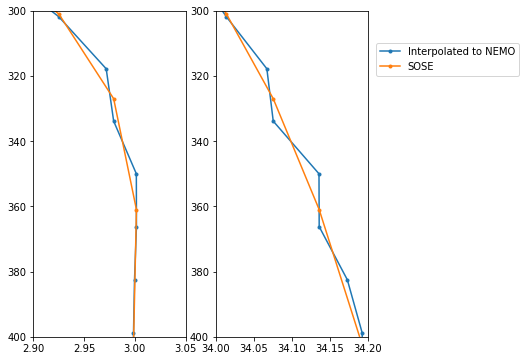

In [449]:
fig, ax = plt.subplots(1,2, figsize=(6,6))
    
ax[0].plot(Temp, SOSE_vert_interp.Z, '.-', label='Interpolated to NEMO')
ax[0].plot(SOSE_horizon_interp.THETA.isel(y=0, x=0), -1*SOSE_depths, '.-', label='SOSE')
ax[0].set_xlim(2.9, 3.05)

ax[1].plot(Salt, SOSE_vert_interp.Z, '.-', label='Interpolated to NEMO')
ax[1].plot(SOSE_horizon_interp.SALT.isel(y=0, x=0), -1*SOSE_depths, '.-', label='SOSE')
ax[1].set_xlim(34.0, 34.2)
ax[1].legend(loc=(1.05, 0.8))

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(400,300)

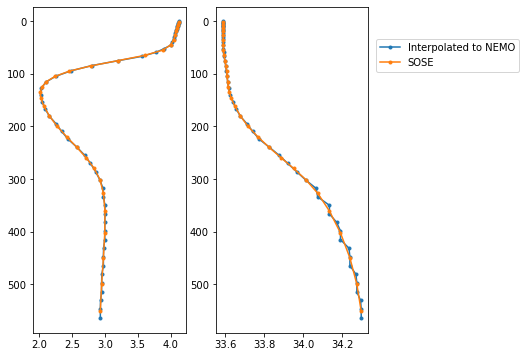

In [453]:
fig, ax = plt.subplots(1,2, figsize=(6,6))
    
ax[0].plot(Temp, mesh.gdept_0.isel(time_counter=0, y=y_ind, x=x_ind), '.-', label='Interpolated to NEMO')
ax[0].plot(SOSE_horizon_interp.THETA.isel(y=0, x=0), -1*SOSE_depths, '.-', label='SOSE')
ax[1].plot(Salt, mesh.gdept_0.isel(time_counter=0, y=y_ind, x=x_ind), '.-', label='Interpolated to NEMO')
ax[1].plot(SOSE_horizon_interp.SALT.isel(y=0, x=0), -1*SOSE_depths, '.-', label='SOSE')

ax[1].legend(loc=(1.05, 0.8))
for axis in ax.ravel():
    axis.invert_yaxis()

### Create climatology of variables

In [18]:
folder_in = '/data/oceans_input/raw_input_data/BSOSE_i139/'
Create
SOSE_var = xr.open_dataset(f'{folder_in}SSH_bsoseI139_2013to2021_5dy.nc')

for month in range(1,13):
    print(month)
    var_mean = SOSE_var.isel(time=(SOSE_var.time.dt.month == month)).mean(dim='time')
    var_mean.to_netcdf(f'{folder_SOSE}ETAN_climatology_m{month:02}.nc')

1
2
3
4
5
6
7
8
9
10
11
12
